# Import Drivers+, Download Overlay

In [2]:
import logging
import sys
import pynq
import time
from pynq import PL

import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio

import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.util
import mkidgen3.plotting
from mkidgen3.plotting import plot_waveforms, plot_res_chan
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc
from mkidgen3.drivers.ifboard import IFBoard
from mkidgen3.testutils import *

In [3]:
#from logging import getLogger, basicConfig
#basicConfig()
#getLogger("mkidgen3.drivers.ifboard").setLevel("DEBUG")

In [4]:
# Download Overlay, Optionally Configure Clocks
bitstream='/home/xilinx/bit/full_design_3core.bit'
ol = g3.overlay_helpers.configure(bitstream, ignore_version=True, clocks=True, external_10mhz=True, download=True)

In [5]:
bram_mmio = ol.photon_pipe.reschan.axi_bram_ctrl_0.mmio

# Define MKID Properties

In [368]:
mkid_f0 = 6.9147654e9-500e6

# Program IF Board

In [325]:
if_board = IFBoard(connect=True)

In [475]:
if_board.power_off()

In [372]:
if_board.set_lo(mkid_f0*1e-6, g2_mode=True)
if_board.set_attens(39.75+6, 30)

In [370]:
print(if_board.status())

IFStatus: Powered, boot 62. LO gen2 fractional mode, full calibration. PLL locked.
	Req: 6414.765 MHz Attained: 6414.765 MHz Err: 0.0 MHz
	DAC attens: (31.75, 14.0)
	ADC Attens: (3.25, 31.75)


# Play Waveform

In [7]:
#Set tones to send (in Hz). Domain is [-2047,2048) MHz. Set the SNR for a noise floor, `'max'` will turn off noise.
tones = np.array([200e6+107e3, 300.5e6-33e3, 400e6+20e3]) 
#tones = np.array([500.2345e6])
amplitudes = np.ones_like(tones)/tones.shape[0]
g3.set_waveform(tones,amplitudes,fpgen='simple')

{'iq': array([-0.26611724+0.0806559j , -0.3142325 -0.09813858j,
        -0.24815969-0.2795386j , ...,  0.1838671 +0.07162893j,
         0.04911914+0.1876888j , -0.1256683 +0.19022864j], dtype=complex64),
 'frequencies': array([2.00109375e+08, 3.00468750e+08, 4.00023438e+08]),
 'phases': array([4.37548016, 1.06680172, 2.82630677])}

# ADC CAPTURE

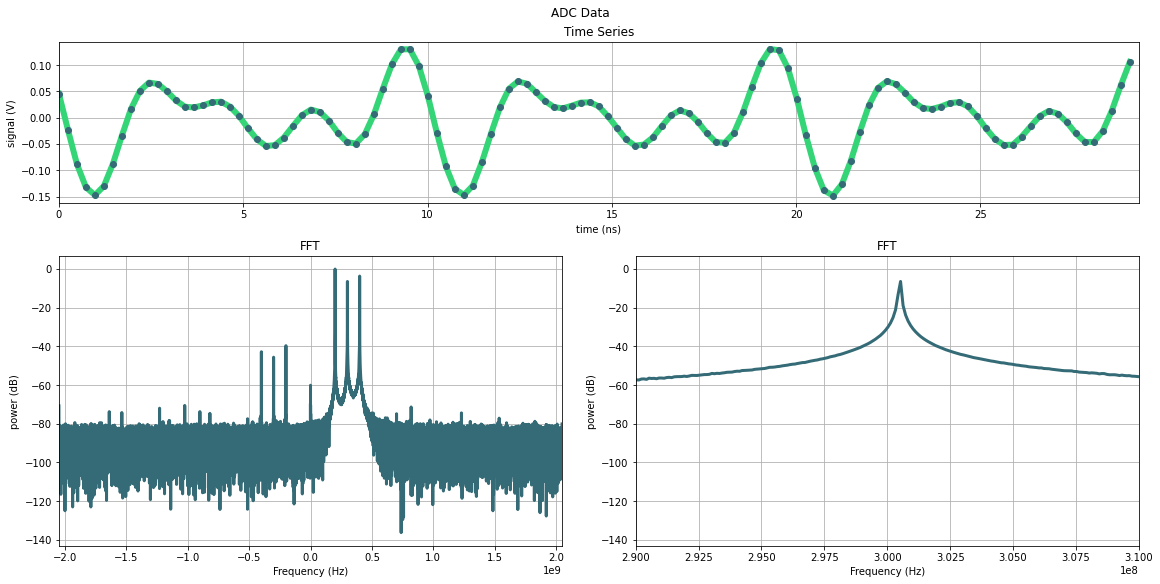

In [8]:
# Trigger Capture
ol.capture.capture_adc(2**19, complex=True) # throw away capture to clear any startup garbage
adc_capture_data = ol.capture.capture_adc(2**19, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (2.9e8, 3.1e8)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

## Assign Resonator Channels

In [9]:
bins = np.zeros(2048, dtype=int)
bins[:tones.size] = g3.opfb_bin_number(tones,ssr_raw_order=True)
ol.photon_pipe.reschan.bin_to_res.bins = bins

## Program DDC

In [10]:
ddc_driver_ob =  mkidgen3.drivers.ddc.ThreepartDDC(bram_mmio)

In [11]:
ddc_tones = np.zeros(2048)
ddc_tones[:tones.size]=tones
ddc_driver_ob.configure_ddc(ddc_tones)  #phase goes from [-pi, pi), like tones.size

# Step LO and Capture IQ Data

In [216]:
def compute_lo_steps(center, resolution, bandwidth):
    """
    inputs:
    - center: float
        center frequency in Hz of the sweep bandwidth
    - resolution: float
        frequency resolution in Hz for the LO sweep
    - bandwidth: float
        bandwidth in Hz for the LO to sweep through
    """
    n_steps = np.round(bandwidth / resolution).astype('int')
    return np.linspace(-bandwidth / 2, bandwidth / 2, n_steps) + center

In [217]:
(4.78e9-500e6+4.98e9-500e6)/2

4380000000.0

In [218]:
4.8825e9-500e6

4382500000.0

In [220]:
mkid_f0

4265041000.0

In [246]:
mkid_f0

4265041000.0

In [379]:
6.9144e9-500e6

6414400000.0

In [380]:
# allow start and stop freq
lo_sweep_freqs=compute_lo_steps(6414400000, 10e3, 2e6)
print(lo_sweep_freqs*1e-6)

[6413.4        6413.41005025 6413.4201005  6413.43015075 6413.44020101
 6413.45025126 6413.46030151 6413.47035176 6413.48040201 6413.49045226
 6413.50050251 6413.51055276 6413.52060302 6413.53065327 6413.54070352
 6413.55075377 6413.56080402 6413.57085427 6413.58090452 6413.59095477
 6413.60100503 6413.61105528 6413.62110553 6413.63115578 6413.64120603
 6413.65125628 6413.66130653 6413.67135678 6413.68140704 6413.69145729
 6413.70150754 6413.71155779 6413.72160804 6413.73165829 6413.74170854
 6413.75175879 6413.76180905 6413.7718593  6413.78190955 6413.7919598
 6413.80201005 6413.8120603  6413.82211055 6413.8321608  6413.84221106
 6413.85226131 6413.86231156 6413.87236181 6413.88241206 6413.89246231
 6413.90251256 6413.91256281 6413.92261307 6413.93266332 6413.94271357
 6413.95276382 6413.96281407 6413.97286432 6413.98291457 6413.99296482
 6414.00301508 6414.01306533 6414.02311558 6414.03316583 6414.04321608
 6414.05326633 6414.06331658 6414.07336683 6414.08341709 6414.09346734
 6414.1

In [381]:
def get_iq_point(n=1024):
    """
    Args:
        n: int
        how many points to average
    Returns: a single averaged iq data point captured from res channel 0
    """
    x = ol.capture.capture_iq(n, [0, 1], tap_location='iq')
    tmp = np.zeros(x.shape[1:])
    x.mean(axis=0, out=tmp)
    x.freebuffer()
    return tmp[0, 0] + 1j * tmp[0, 1]

# Sweep

In [455]:
iq_vals = np.zeros(lo_sweep_freqs.size, dtype=np.complex64)
lo_settings = np.zeros(lo_sweep_freqs.size)
for x in range(len(lo_sweep_freqs)):
    if_board.set_lo(lo_sweep_freqs[x] * 1e-6)
    iq_vals[x] = get_iq_point()

# Plot Data

In [461]:
def plot_sweep(freqs, iq_vals, ax=None, fig=None):
    plt.rcParams.update({'font.size': 12})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'{(mkid_f0+500e6) * 1e-9} GHz Resonator', fontsize=15)

    ax1.plot((freqs+500e6) * 1e-9, 20 * np.log10(np.abs(iq_vals)), linestyle=" ", marker=".")
    ax1.set_ylabel('|S21| [dB]')
    ax1.set_xlabel('Frequency [GHz]')
    ax1.set_title('Transmission')
    ax2.plot(iq_vals.real, iq_vals.imag, 'o')
    ax2.set_xlabel('Real(S21)')
    ax2.set_xlim([-0.035,0.02])
    ax2.set_ylim([-0.035,0.02])
    ax2.set_ylabel('Imag(S21)')
    ax2.set_title('IQ Loop')

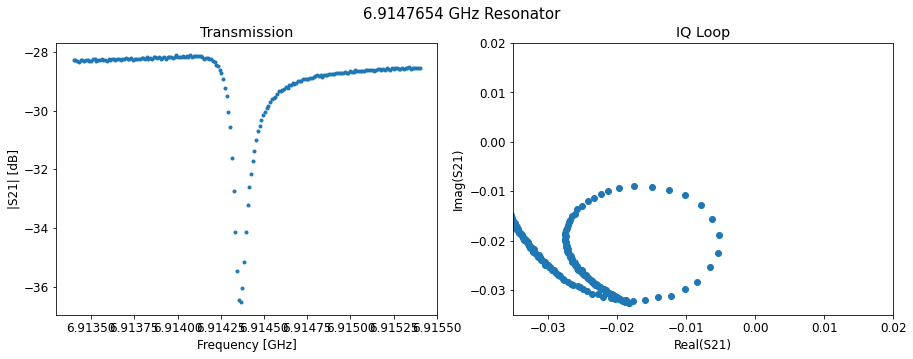

In [462]:
plot_sweep(lo_sweep_freqs, iq_vals/2**15)

# Determine Loop Center

In [403]:
def est_loop_center(iq):
    """
    Finds the (I,Q) centers of the loops via percentile math
    iq - np.complex array[n_loops, n_samples]
    returns centers[iq.shape[0]]

    see mkidgen2.roach2controls.fitLoopCenters for history
    """
    ictr = (np.percentile(iq.real, 95) + np.percentile(iq.real, 5)) / 2
    qctr = (np.percentile(iq.imag, 95) + np.percentile(iq.imag, 5)) / 2

    return ictr + qctr * 1j

In [404]:
est_loop_center(iq_vals/2**15)

(-0.02422066554427147-0.02250640839338303j)

# Reprogram DDC with Loop Center

In [448]:
ddc_centers = np.zeros(2048, dtype=np.complex64)
ddc_centers[:tones.size]=0.0-0*1j#-0.015-0.02*1j
ddc_driver_ob.configure_ddc(ddc_tones, phase_offsets, loop_center=ddc_centers, center_relative=False, quantize=True)

# ReSweep

In [449]:
iq_vals_centered = np.zeros(lo_sweep_freqs.size, dtype=np.complex64)
for x in range(len(lo_sweep_freqs)):
    if_board.set_lo(lo_sweep_freqs[x] * 1e-6)
    iq_vals_centered[x] = get_iq_point()

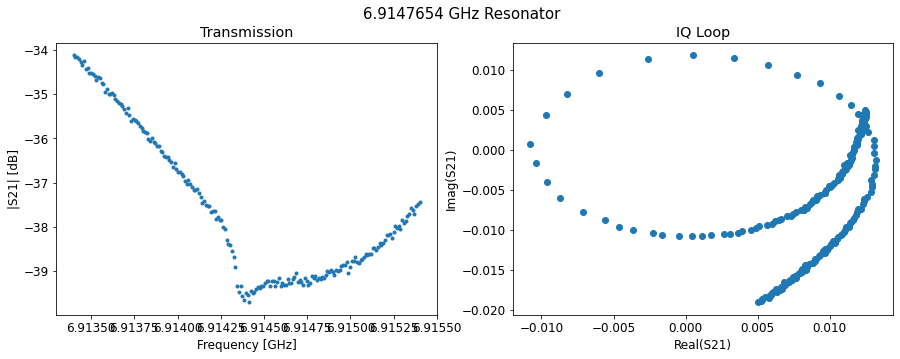

In [450]:
plot_sweep(lo_sweep_freqs, iq_vals_centered/2**15)

In [78]:
from scipy.signal import welch, lfilter

In [79]:
def plot_psd(data, fs=1e6, fres=1e3, ax=None, fig=None, **kwargs):
    plt.figure()
    default = {'fs': fs, 'nperseg': fs / fres}
    default.update(kwargs)
    f, psd = welch(data, **default)
    plt.semilogx(f, 10 * np.log10(psd))
    plt.xlabel(f'Frequency [Hz] ({fres * 1e-3:g} kHz resolution)')
    plt.ylabel('dB/Hz')
    plt.grid()
    plt.title('Power Spectral Density')

In [80]:
x = ol.capture.capture_phase(2**19, [0,1], tap_location='rawphase')
phase = np.array(x)
x.freebuffer()

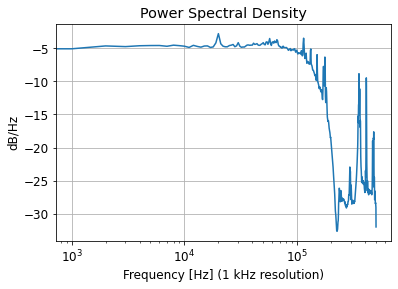

In [93]:
plot_psd((phase[:,0])*np.pi)

In [12]:
riq, iq = ol.capture.ddc_compare_cap()

903 903


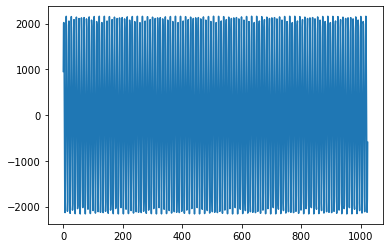

In [47]:
plt.plot(riq[:,0].real)

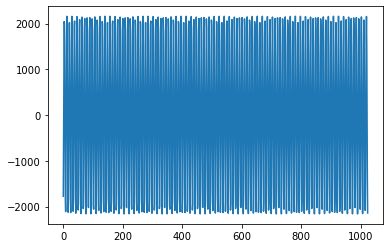

In [48]:
plt.plot(iq[:,0].real)

# Capture Phase

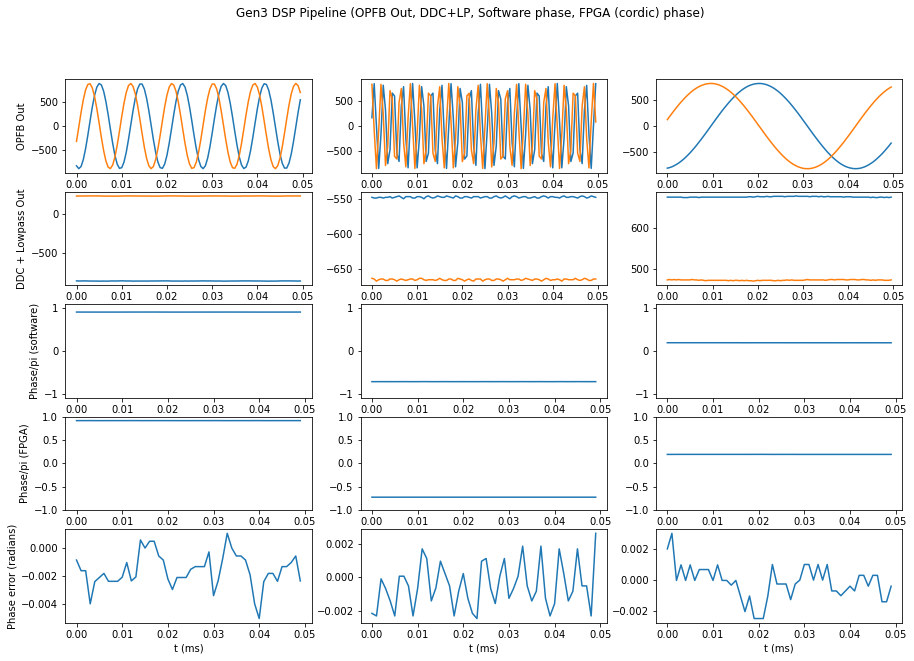

In [13]:
iq, phase = ol.capture.cap_cordic_compare()
tonesplt = tones
chan_plt=[0,1,2]
bin_centers = g3.opfb_bin_center(g3.opfb_bin_number(tonesplt, ssr_raw_order=True), ssr_order=True)
fig, axes = plt.subplots(5,3, figsize=(15,10))
tones_khz=g3.drivers.ddc.tone_increments(tonesplt, quantize=True)*1e3
for j,(i, ax) in enumerate(zip(chan_plt,axes.T)):
    plot_waveforms(riq[:100, i], 2e6, ax=ax[0], label='OPFB Out' if not j else '')
    plot_waveforms(iq[:100, i], 2e6, sw_phase=False, ax=ax[1], label='DDC + Lowpass Out' if not j else '')
    plot_waveforms(iq[:50, i], 1e6, sw_phase = True, ax=ax[2], label='Phase/pi (software)' if not j else '')
    plot_waveforms(phase[:50, i]/2**15, 1e6, cordic=True, ax=ax[3], label='Phase/pi (FPGA)' if not j else '')
    plt.ylim([-1,1])
    err=np.angle(iq[:50, i])-np.pi*phase[:50, i]/2**15
    plot_waveforms(err, 1e6, cordic=True, ax=ax[4], label='Phase error (radians)' if not j else '')
    #plt.ylim([-1,1])
plt.suptitle('Gen3 DSP Pipeline (OPFB Out, DDC+LP, Software phase, FPGA (cordic) phase)');

## Optimal Filter

In [14]:
unity=np.zeros(30, dtype=np.int16)
unity[0] = 2**15-1

In [15]:
## RAW
phases={}
n_points=1024
x = ol.capture.capture_phase(n_points, [0,1], tap_location='rawphase')
phases['raw']=np.array(x)
x.freebuffer()

## LOAD UNITY FILTER EVERY CHANNEL
ol.photon_pipe.phasematch.load_coeff(0,unity, vet=False, raw=True)
ol.photon_pipe.phasematch.load_coeff(1,unity, vet=False, raw=True)
ol.photon_pipe.phasematch.load_coeff(2,unity, vet=False, raw=True, force_commit=True)
time.sleep(1)
# Capture
x = ol.capture.capture_phase(n_points, 'all', tap_location='phase')
phases['unity']=np.array(x)
x.freebuffer()

/home/xilinx/src/mkidgen3/mkidgen3/drivers/axififo.py:43: RuntimeWarning: coroutine 'Interrupt.wait' was never awaited
  self.interrupt.wait()  # wait for the transmit to complete


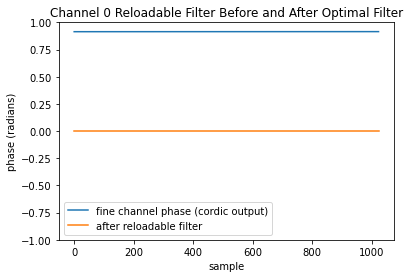

In [16]:
plt.plot(phases['raw'][:,0]/(2**15-1))
plt.plot((phases['unity'][::,0])/(2**15-1))
plt.ylim([-1,1]);
plt.xlabel('sample')
plt.ylabel('phase (radians)')
plt.legend(['fine channel phase (cordic output)', 'after reloadable filter'])
plt.title('Channel 0 Reloadable Filter Before and After Optimal Filter');

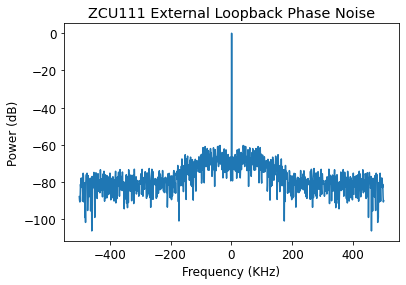

In [169]:
phase_fft = 20*np.log10(np.fft.fftshift(np.abs(np.fft.fft(phases['raw'][:,0]))))
phase_fft = phase_fft - max(phase_fft)
plt.plot(np.linspace(-0.5e3,0.5e3,phase_fft.size),phase_fft)
plt.xlabel('Frequency (KHz)')
plt.ylabel('Power (dB)')
plt.title('ZCU111 External Loopback Phase Noise');

# Bias Phase

In [70]:
phase_offsets = np.zeros(2048)
ddc_centers = np.zeros(2048, dtype=np.complex64)
ddc_driver_ob.configure_ddc(ddc_tones, phase_offsets, ddc_centers, center_relative=False, quantize=True)

In [71]:
x = ol.capture.capture_phase(2**19, [0,1], tap_location='rawphase')
phase = np.array(x)
x.freebuffer()
raw_phase1 = phase[:,0]/(2**15-1)
raw_phase2 = phase[:,1]/(2**15-1)
raw_phase3 = phase[:,2]/(2**15-1)

In [72]:
phase_offsets[:tones.size]=[-np.average(raw_phase1)*np.pi, -np.average(raw_phase2)*np.pi, -np.average(raw_phase3)*np.pi]
#phase_offsets = None
ddc_driver_ob.configure_ddc(ddc_tones, phase_offsets, ddc_centers, center_relative=False, quantize=True)

In [73]:
phase_offsets

array([-2.87229346,  2.25988825, -0.6081897 , ...,  0.        ,
        0.        ,  0.        ])

In [74]:
x = ol.capture.capture_phase(2**19, [0,1], tap_location='rawphase')
phase = np.array(x)
x.freebuffer()
moved_phase1 = phase[:,0]/(2**15-1)
moved_phase2 = phase[:,1]/(2**15-1)
moved_phase3 = phase[:,2]/(2**15-1)

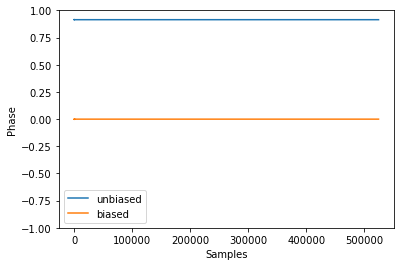

In [75]:
plt.plot(raw_phase1)
plt.plot(moved_phase1)
plt.ylim([-1,1]);
plt.ylabel('Phase')
plt.xlabel('Samples')
plt.legend(['unbiased','biased']);

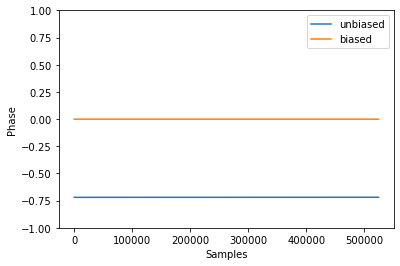

In [76]:
plt.plot(raw_phase2)
plt.plot(moved_phase2)
plt.ylim([-1,1]);
plt.ylabel('Phase')
plt.xlabel('Samples')
plt.legend(['unbiased','biased']);

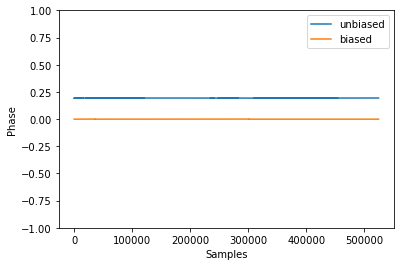

In [77]:
plt.plot(raw_phase3)
plt.plot(moved_phase3)
plt.ylim([-1,1]);
plt.ylabel('Phase')
plt.xlabel('Samples')
plt.legend(['unbiased','biased']);

# ReSweep

In [438]:
iq_vals_biased = np.zeros(lo_sweep_freqs.size, dtype=np.complex64)
for x in range(len(lo_sweep_freqs)):
    if_board.set_lo(lo_sweep_freqs[x] * 1e-6)
    iq_vals_biased[x] = get_iq_point()

In [451]:
iq_vals_centered = np.zeros(lo_sweep_freqs.size, dtype=np.complex64)
for x in range(len(lo_sweep_freqs)):
    if_board.set_lo(lo_sweep_freqs[x] * 1e-6)
    iq_vals_centered[x] = get_iq_point()

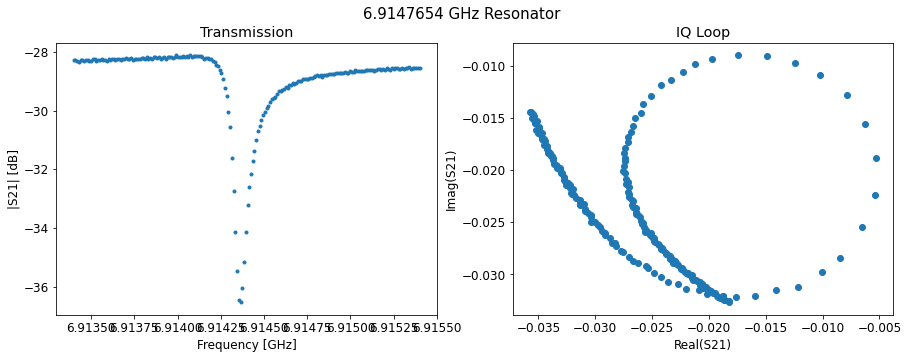

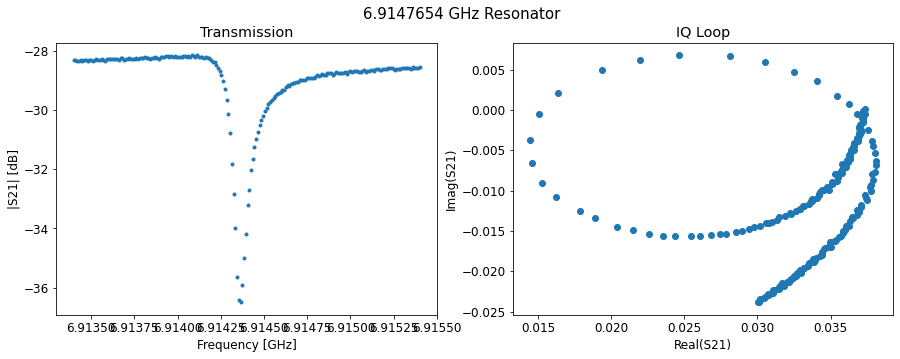

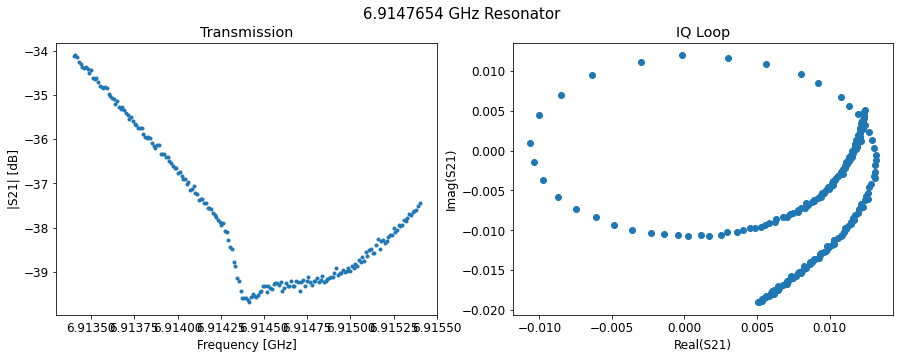

In [458]:
plot_sweep(lo_sweep_freqs, iq_vals/2**15)
plot_sweep(lo_sweep_freqs, iq_vals_biased/2**15)
plot_sweep(lo_sweep_freqs, iq_vals_centered/2**15)

In [463]:
import scipy.io as sio

In [465]:
mdic = {"raw": iq_vals, "rotated": iq_vals_biased, "centered": iq_vals_centered}

In [469]:
sio.savemat('loopdata.mat', mdic)

In [467]:
x = ol.capture.capture_phase(2**19, [0,1], tap_location='rawphase')
phase = np.array(x)
x.freebuffer()

In [472]:
phase_out = phase[:,0]+phase[:,1]*1j

In [468]:
mdic = {"raw": iq_vals, "rotated": iq_vals_biased, "centered": iq_vals_centered, "phase_data": phase}

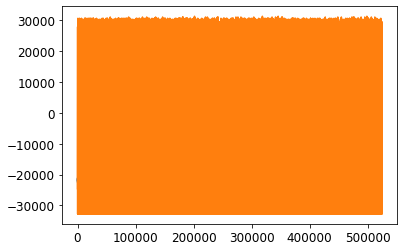

In [474]:
plt.plot(phase_out.real)
plt.plot(phase_out.imag)